# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `Team 16`
* Students: `Yinan Zhang, Yuting Huang, Shengzhao Xia, Zhantao Deng`
* Dataset: `IMDb`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some **Graph Signal Processing (GSP)** on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
**There are several ways from which you could approach it.**
In all cases, **compute the position of the nodes** a **single time** at the beginning, as this is likely to be a costly operation.
Using a **single layout** for all the graph plots will also make it easier to compare the plots.
Indeed, the **only thing changing between plots** is the **signal displayed**.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a **consistent color map** throughout and remember to **display a colorbar and scale** in all plots, so that we can tell **what numbers the colors represent**.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to **embed your graph on the plane**. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to **try all** the above methods before making your choice. Then **be consistent and use only one** throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
# Math Package
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

# Networks Package
import networkx as nx 
from pygsp import graphs, filters, plotting

# Plot Package
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plotting.BACKEND = 'matplotlib'

In [3]:
# load adjacency matrix
adjacency = np.load('adjacency_credits_linear.npy')  
labels = np.load('label_credit_line.npy')

# compute nodes and degrees
n_nodes = adjacency.shape[0]
degree = np.sum(adjacency, axis = 1)

# compute laplacian and normalized laplacian
adjacency_csr = sparse.csr_matrix(adjacency)
degree_csr = sparse.csr_matrix(np.diag(degree))

laplacian_combinatorial = degree_csr - adjacency_csr
laplacian_normalized    = degree_csr.power(-0.5).dot(laplacian_combinatorial).dot(degree_csr.power(-0.5))

laplacian_combinatorial = laplacian_combinatorial.toarray()
laplacian_normalized    = laplacian_normalized.toarray()

For this milestone, **all we will need** is **a set of features/labels** for **each of the nodes** on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: **If your features/labels are not floating-point numbers**, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

**To make this notebook easy to read, we defined some funtions here**

In [4]:
def compute_gradient_matrix(adjacency):
    '''
       Compute gradient matrix. 
    '''
    adjacency_csr = sparse.csr_matrix(adjacency)
    nz_row, nz_col = sparse.tril(adjacency_csr).nonzero()
    weights = adjacency_csr[nz_row, nz_col]
    weights = np.squeeze(np.array(weights))
    gradient_matrix_T = np.zeros((nz_row.shape[0], n_nodes))
    for k in range(nz_row.shape[0]):
        gradient_matrix_T[k,nz_row[k]] = np.sqrt(weights[k])
        gradient_matrix_T[k,nz_col[k]] = -np.sqrt(weights[k])
    return gradient_matrix_T

In [24]:
def graph_visual(values):
    '''
        Visualize graphs.
    '''
    graph = nx.from_scipy_sparse_matrix(sparse.csr_matrix(adjacency))
    coords = evecs_norm[:, 1:3]  # Laplacian eigenmaps.
    nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=labels.squeeze())
    nx.draw_networkx_edges(graph, coords, alpha=0.3)
    gain = np.append(np.zeros([values.shape[0],1]), values.reshape(values.shape[0],1), axis=1)
    x = coords + gain
    for i in range(len(x)):
        x_cord = [x[i][0], coords[i][0]]
        y_cord = [x[i][1], coords[i][1]]
        plt.plot(x_cord, y_cord, 'b', linewidth = 0.1,linestyle='-')

In [19]:
def scatter3d_signal(signal, zlimit = [0,7], size = [10,6], colormap = 'bwr', name = 'node scatter',
                     xlabel = 'x', ylabel = 'y', zlabel = 'z', title = 'title'):
    '''
        Scatter plot signal in 3-D.
    '''
    fig = plt.figure(figsize=size)
    ax = fig.gca(projection='3d')

    x = evecs_norm[:, 1]
    y = evecs_norm[:, 2]

    ax.scatter(x, y, signal, zdir='z', c = signal , cmap = colormap , label = name)

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlim(-0.001,0.02)
    ax.set_ylim(-0.1,0.2)
    ax.set_zlim(zlimit)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    ax.view_init(elev=15., azim=-60)
    plt.show()

In [11]:
gradient = compute_gradient_matrix(adjacency).dot(labels)
gradient_matrix_T = compute_gradient_matrix(adjacency)
gradient_matrix_T = sparse.csr_matrix(gradient_matrix_T)

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [7]:
evals_norm,   evecs_norm   = np.linalg.eigh(laplacian_normalized)
evals_unnorm, evecs_unnorm = np.linalg.eigh(laplacian_combinatorial)

In [8]:
e = evals_unnorm  # Ordered Laplacian eigenvalues.
U = evecs_unnorm  # Ordered graph Fourier basis.

Plot the **first 3 and the last Fourier basis vectors as signals** on your graph. **Clearly indicate which plot belongs to which basis vector.**

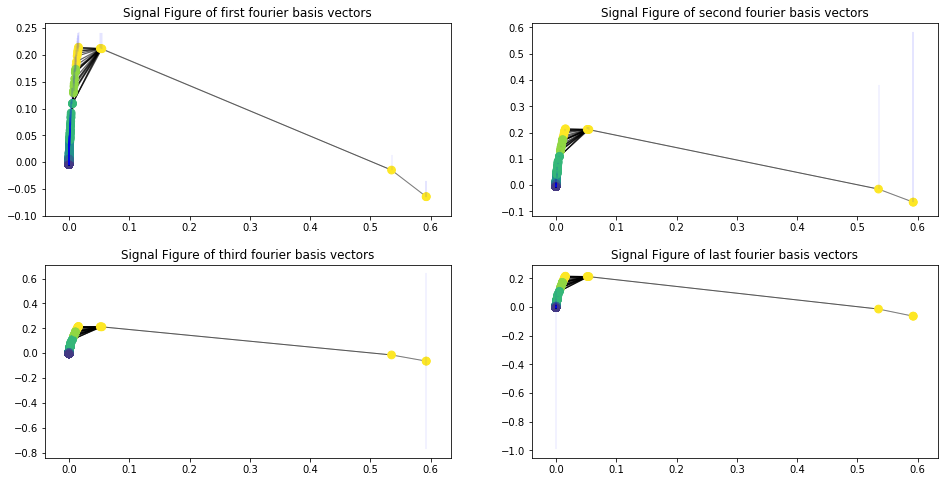

In [14]:
# Plot fourier basis vectors as signals
fig = plt.figure(figsize=[16,8])
fig.subplots_adjust(hspace=0.25)

plt.subplot(221)
graph_visual(evecs_unnorm[:,0])
plt.title("Signal Figure of first fourier basis vectors")

plt.subplot(222)
graph_visual(evecs_unnorm[:,1])
plt.title("Signal Figure of second fourier basis vectors")

plt.subplot(223)
graph_visual(evecs_unnorm[:,2])
plt.title("Signal Figure of third fourier basis vectors")

plt.subplot(224)
graph_visual(evecs_unnorm[:,-1])
plt.title("Signal Figure of last fourier basis vectors")

plt.show()

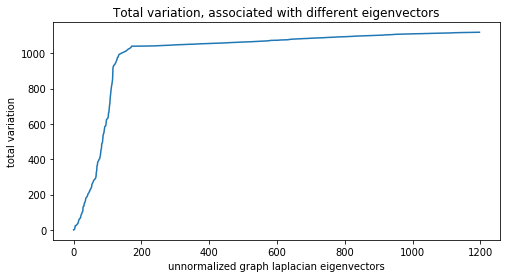

In [63]:
#calculate total variation, using eigenvectors as signals
total_variation = []
for i in range(n_nodes):
    total_variation.append(U[:,i].T@laplacian_combinatorial@U[:,i])
plt.figure(figsize=[8,4])
plt.xlabel("unnormalized graph laplacian eigenvectors")
plt.ylabel("total variation")
plt.title("Total variation, associated with different eigenvectors")
plt.plot(total_variation)
plt.show()

### Question 2

What can you observe in terms of **local variations** when comparing the **basis vectors** corresponding to the **smallest eigenvalues** to those corresponding to the **largest eigenvalue**? How would this justify the interpretation of the **eigenvalues as "graph frequencies"**?

**Your answer here.**

> The eigenvector associated with eigenvalue 0 is constant. The eigenvectors associated with large eigenvalues oscillate rapidly and are more likely to have dissimilar values on vertices connected by an edge with high weight. The eigenvectors associated with small eigenvalues vary slowly and are more likely to have similar values on vertices connected by edges with high weight. That's why the laplacian eigenvalues can be interpreted as frequencies [[1]](https://ieeexplore.ieee.org/document/6494675).<br><br>
> As shown above, eigenvectors associated with large eigenvalues have larger total variation, which means non-smooth.

### Question 3

Implement a function that returns the **Graph Fourier Transform (GFT)** of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [10]:
def GFT(x):
    return U.T.dot(x)

def iGFT(x):
    return U.dot(x)

### Question 4

Plot your feature/label vector as a signal on your graph.

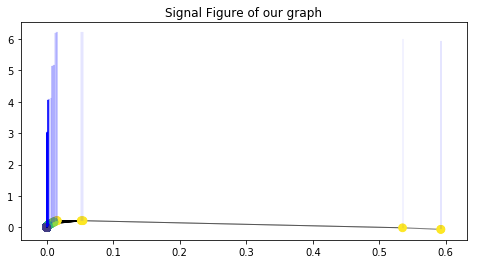

In [25]:
plt.figure(figsize=[8,4])
graph_visual(labels)
plt.title("Signal Figure of our graph")
plt.show()

Since there are only a few of nodes belonging to label 0 and label 1, we can not distinguish them from other points in the figure above. Therefore, we plot a 3D scatter plot as follow.

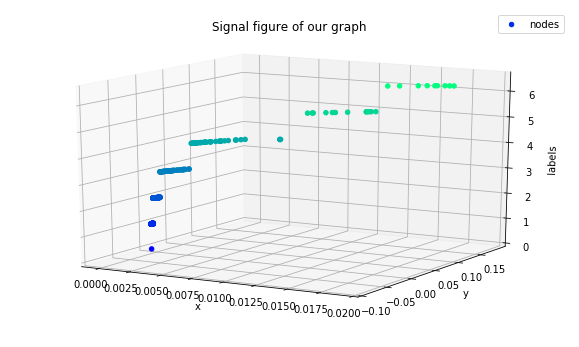

In [20]:
scatter3d_signal(labels.reshape(labels.shape[0],), colormap = 'winter' , 
                 zlimit = [0.9*np.min(labels), 1.1*np.max(labels)], 
                 name = 'nodes', zlabel = 'labels', title = 'Signal figure of our graph' )

In the 3D scatter plot, each point represents a node of our graph and the z coordinate of each node is equal to the label of the node. To make it easier to distinguish nodes that share different labels, we allocate different colors to different labels. 

From the figure above we can see that our network has 7 labels, from 0 to 6.  

Plot the **absolute values of the GFT** of your feature/label signal **as a function of the graph eigenvalues**. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

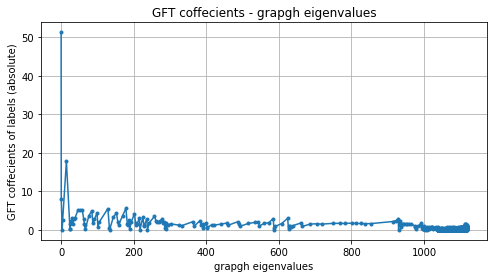

In [11]:
# Your code here.
plt.figure(figsize=(8,4))
plt.plot(evals_unnorm, np.abs(GFT(labels)), '.-')
plt.grid()
plt.title('GFT coffecients - grapgh eigenvalues')
plt.xlabel('grapgh eigenvalues')
plt.ylabel('GFT coffecients of labels (absolute)')
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Your answer here.**

>Via the GFT of the label signal, we can see that most of the energy lies in low frequencies. Thus our labels can be considered as a "low-pass" signal, which means that in our graph, if two nodes are connected by an edge with a high weight, they will share similar labels.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [21]:
def heat_kernel(e, t):
    return np.diag(np.exp(-t*e))

def inverse_kernel(e, t):
    return np.linalg.inv((np.eye(e.shape[0]) + t*np.diag(e)))

def rectangle_kernel(e, l_min, l_max):
    e_new = []
    for i in e:
        e_new.append(1 if i>=l_min and i<=l_max else 0)
    return np.diag(e_new)

def graph_filter(x, kernel, **kwargs):
    if kernel == heat_kernel:
        associated_frame = U.dot(kernel(kwargs['e'], kwargs['t'])).dot(U.T)
    if kernel == inverse_kernel:
        associated_frame = U.dot(kernel(kwargs['e'], kwargs['t'])).dot(U.T)
    if kernel == rectangle_kernel:
        associated_frame = U.dot(kernel(kwargs['e'], kwargs['l_min'], kwargs['l_max'])).dot(U.T)
    return np.dot(associated_frame, x)

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

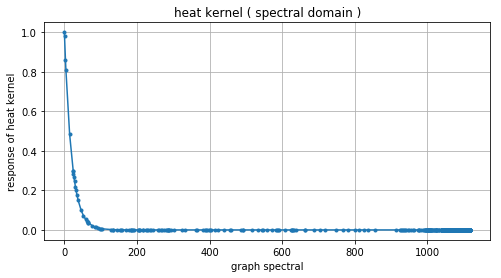

In [23]:
# heat_kernel
plt.figure(figsize=(8, 4))
plt.plot(evals_unnorm, np.diag(heat_kernel(evals_unnorm, 0.05)), '.-');
plt.grid()
plt.title('heat kernel ( spectral domain )')
plt.xlabel('graph spectral')
plt.ylabel('response of heat kernel')
plt.show()

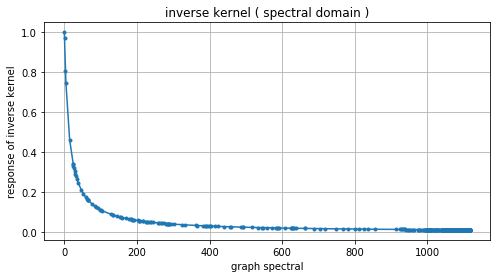

In [29]:
# inverse_kernel
plt.figure(figsize=(8, 4))
plt.plot(evals_unnorm, np.diag(inverse_kernel(evals_unnorm, 0.08)), '.-')
plt.grid()
plt.title('inverse kernel ( spectral domain )')
plt.xlabel('graph spectral')
plt.ylabel('response of inverse kernel')
plt.show()

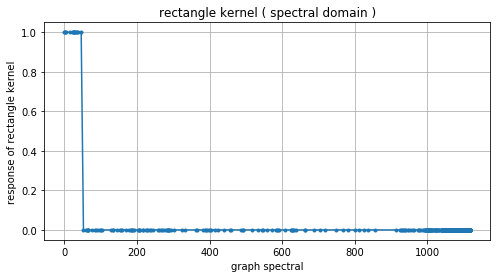

In [30]:
# rectangle_kernel
plt.figure(figsize=(8, 4))
plt.plot(evals_unnorm, np.diag(rectangle_kernel(evals_unnorm, 0, 50)),'.-')
plt.grid()
plt.title('rectangle kernel ( spectral domain )')
plt.xlabel('graph spectral')
plt.ylabel('response of rectangle kernel')
plt.show()

Viewing from the three figures, it is obvious that rectangle kernel is similiarly to a rectangular window in frequency domain, while the heat kernel and inverse kernel are more smooth. Different from the slow decay of inverse kernel, heat kernel features a fast decay and it only passes signals with a frequency lower than a certain cutoff frequency (decided by the constant $t$).

Comparing the three spectrums with out label spectrum, we believe the inverse kernel approximates our label signal better.

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

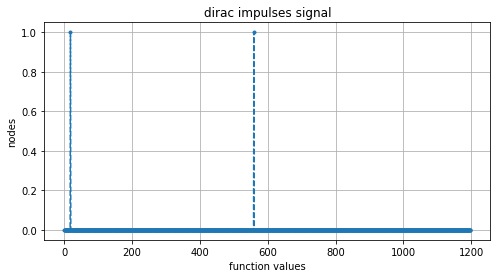

In [31]:
# Your code here.
np.random.seed(521)
indices = np.random.randint(low = 0, high = e.shape[0], size=(1,2))

Dirac_fun = np.zeros(e.shape)
Dirac_fun[indices] = 1

plt.figure(figsize=(8, 4))
plt.plot(Dirac_fun, '.--')
plt.grid()
plt.title('dirac impulses signal')
plt.xlabel('function values')
plt.ylabel('nodes')
plt.show()

In [43]:
Dirac_heat_out = graph_filter(Dirac_fun,  heat_kernel     , e = e, t = 0.01 )
Dirac_invr_out = graph_filter(Dirac_fun,  inverse_kernel  , e = e, t = 0.01 )
Dirac_rect_out = graph_filter(Dirac_fun,  rectangle_kernel, e = e, l_min=0, l_max=50)

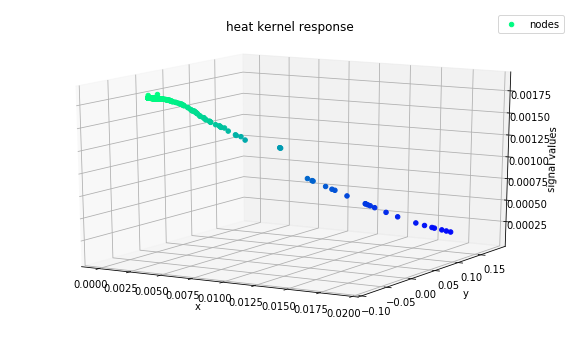

In [44]:
scatter3d_signal(Dirac_heat_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_heat_out), 1.1*np.max(Dirac_heat_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'heat kernel response')

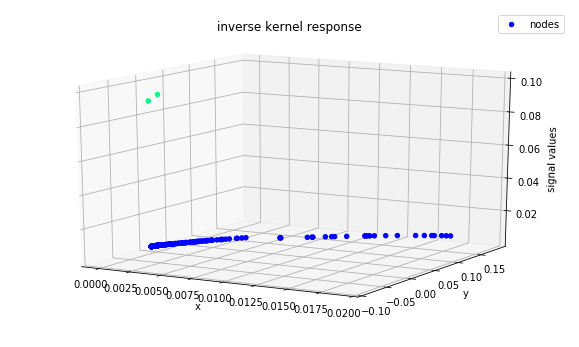

In [45]:
scatter3d_signal(Dirac_invr_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_invr_out), 1.1*np.max(Dirac_invr_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'inverse kernel response')

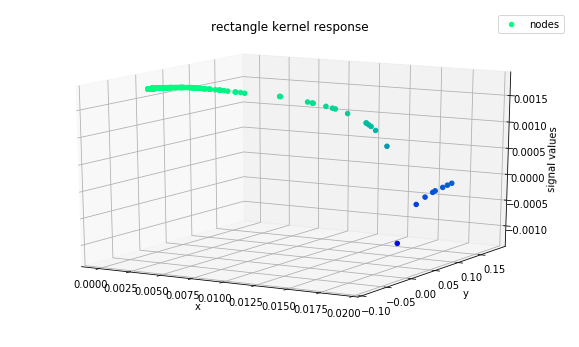

In [46]:
scatter3d_signal(Dirac_rect_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_rect_out), 1.1*np.max(Dirac_rect_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'rectangle kernel response')

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

In order to visualize the diffusion of Diracs, we plot several heat kernel responses which use different $t$.

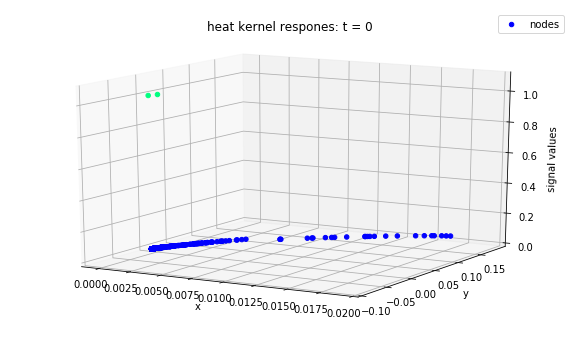

In [31]:
Dirac_heat_out = graph_filter(Dirac_fun, heat_kernel, e = e, t = 0)
scatter3d_signal(Dirac_heat_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_heat_out), 1.1*np.max(Dirac_heat_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'heat kernel respones: t = 0')

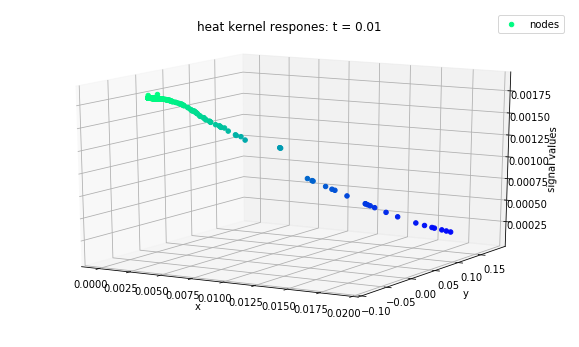

In [30]:
Dirac_heat_out = graph_filter(Dirac_fun, heat_kernel, e = e, t = 0.01)
scatter3d_signal(Dirac_heat_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_heat_out), 1.1*np.max(Dirac_heat_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'heat kernel respones: t = 0.01')

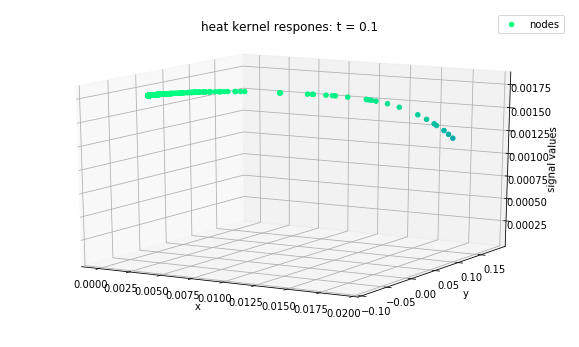

In [32]:
Dirac_heat_out = graph_filter(Dirac_fun, heat_kernel, e = e, t = 0.1)
scatter3d_signal(Dirac_heat_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_heat_out), 1.1*np.max(Dirac_heat_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'heat kernel respones: t = 0.1')

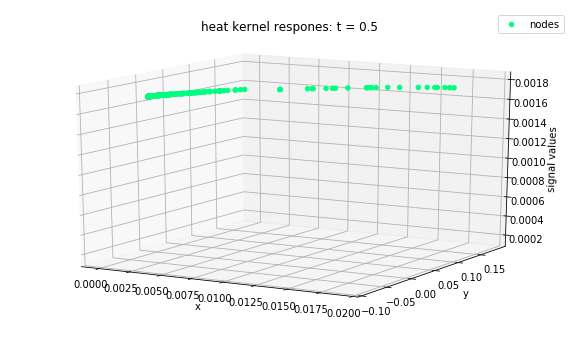

In [33]:
Dirac_heat_out = graph_filter(Dirac_fun, heat_kernel, e = e, t = 0.5)
scatter3d_signal(Dirac_heat_out, 
                 colormap = 'winter',
                 zlimit = [0.9*np.min(Dirac_heat_out), 1.1*np.max(Dirac_heat_out)], 
                 name = 'nodes', zlabel = 'signal values', title = 'heat kernel respones: t = 0.5')

**Your answer here.**

>There is a noticable diffusion phenomenon induced by heat-kernel. As we increase the time step, the energy is spread out gradually; Finally, all nodes will have nonzero signal, which also indicates that our graph is connected. In addition, we can see that the energy of the diffusion is conserved.

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [50]:
labels = labels.squeeze()

SNR = 1.5
noise_variance = np.var(labels)/SNR
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(labels.shape[0])

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Your answer here.**
$$ 2(z^\star-y)  + \gamma (L z^\star + L^{\top} z^\star) = 0, $$
$$ (2 + \gamma L + \gamma L^{\top} )z^\star = 2y, $$
$$ z^\star = (1 + \gamma L)^{-1} y$$

This corresponds to the inverse filter; namely, inverse filter is the optimal reconstruction for image denoising.

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [64]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, e=evals_unnorm, t=0.003)
z_inv_denoised  = graph_filter(noisy_measurements, inverse_kernel, e=evals_unnorm, t=0.003)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, e=evals_unnorm, l_min=0, l_max=50)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [66]:
def relative_error( groudtruth, estimation ):
    return np.linalg.norm(groudtruth - estimation, 2)/np.linalg.norm(groudtruth,2)

The relative error of the original signal is: 0.0


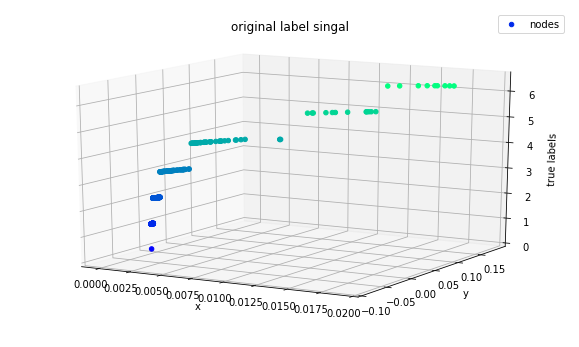

In [69]:
print('The relative error of the original signal is:', relative_error(labels, labels))

scatter3d_signal(labels, colormap = 'winter', zlimit = [0.9*np.min(labels), 1.1*np.max(labels)], 
                 name = 'nodes', zlabel = 'true labels', title = 'original label singal')

The relative error of the noised signal is: 0.44178918084138635


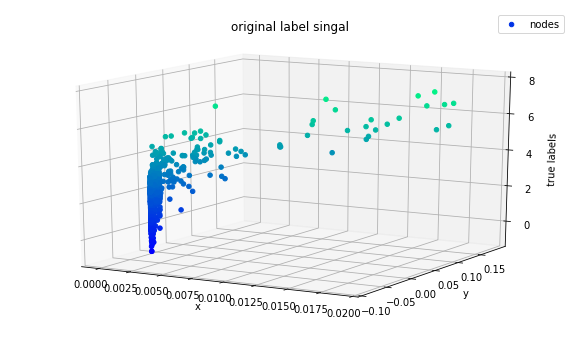

In [85]:
print('The relative error of the noised signal is:', relative_error(labels, noisy_measurements))

scatter3d_signal(noisy_measurements, colormap = 'winter', zlimit = [0.9*np.min(noisy_measurements), 1.1*np.max(noisy_measurements)], 
                 name = 'nodes', zlabel = 'true labels', title = 'original label singal')

The relative error of after heat-kernel denoising is: 0.28082111968575973


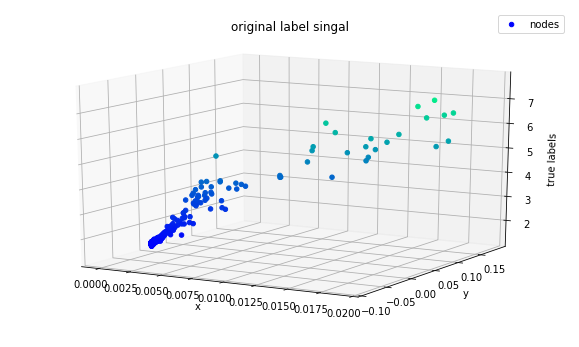

In [86]:
print('The relative error of after heat-kernel denoising is:', relative_error(labels, z_heat_denoised))

scatter3d_signal(z_heat_denoised, colormap = 'winter', zlimit = [0.9*np.min(z_heat_denoised), 1.1*np.max(z_heat_denoised)], 
                 name = 'nodes', zlabel = 'true labels', title = 'original label singal')

The relative error of after inverse-kernel denoising is: 0.24863214336393336


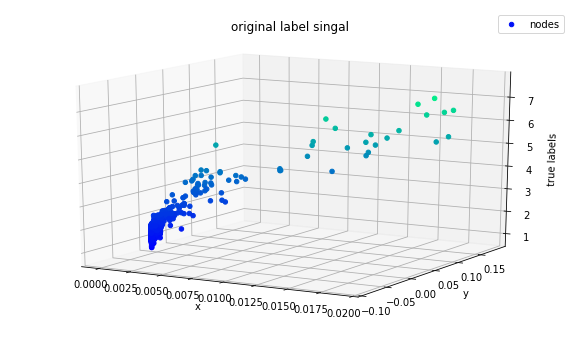

In [87]:
print('The relative error of after inverse-kernel denoising is:', relative_error(labels, z_inv_denoised))

scatter3d_signal(z_inv_denoised, colormap = 'winter', zlimit = [0.9*np.min(z_inv_denoised), 1.1*np.max(z_inv_denoised)], 
                 name = 'nodes', zlabel = 'true labels', title = 'original label singal')

The relative error of after rectangle-kernel denoising is: 0.4195926992409784


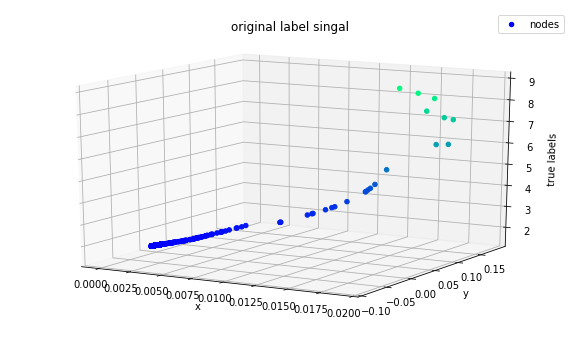

In [88]:
print('The relative error of after rectangle-kernel denoising is:', relative_error(labels, z_rect_denoised))

scatter3d_signal(z_rect_denoised, colormap = 'winter', zlimit = [0.9*np.min(z_rect_denoised), 1.1*np.max(z_rect_denoised)], 
                 name = 'nodes', zlabel = 'true labels', title = 'original label singal')

Finally, overlay on the same plot the GFT of all five signals above.

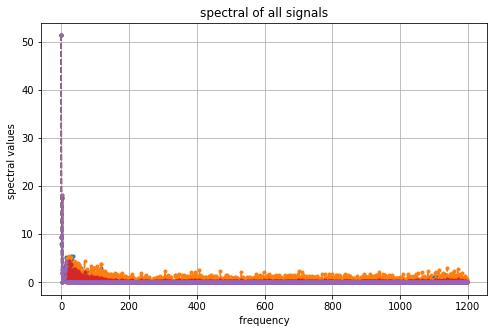

In [122]:
# Your code here.
plt.figure(figsize=(8, 5))
plt.plot(range(labels.shape[0]), np.abs(GFT(labels))            , '.--',
         range(labels.shape[0]), np.abs(GFT(noisy_measurements)), '.--',
         range(labels.shape[0]), np.abs(GFT(z_heat_denoised))   , '.--',
         range(labels.shape[0]), np.abs(GFT(z_inv_denoised))    , '.--',
         range(labels.shape[0]), np.abs(GFT(z_rect_denoised))   , '.--');

plt.grid()
plt.title('spectral of all signals')
plt.xlabel(' frequency ')
plt.ylabel('spectral values ')

plt.show()

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Your answer here.**

> 1. As we can see from the relative errors, the relative error of inverse kernel is around 0.2486, which outperforms the error of heat kernel and rectangle kernel whose errors are 0.2808 and 0.4196, repectively. <br><br>
>2. When we look at the 5 scatter plots above, we observe that the denoising results of inverse kernel preserve the shape of original signal better than the heat kernel and rectangle kernel, especially in label 0, 1 and 2. <br><br>
>3. The rectangle kernel is a rectangular window filter, which passes all signals below a certain frequency without loss while filt all signals above the cutoff frequency; the heat kernel is a low-pass filter with a cutoff frequency and it diplays the connectivity of the network; the inverse kernel is also a low-pass filter but different from heat kernel, inverse kernel shows a slow decay over high frequency components. Our label sigal is a low frequency signal with some high frequency components. therefore, intuitively, inverse kernel should perform better, since it perserves high frequency components. <br><br>
>4. As discussed in the begining of Question 11, the inverse kernel is the optimal reconstruction for noisy image. So we can conclude that this conclusion holds for our dataset, our label signal is best denoised by the inverse kernel.

## 4 - Transductive learning

It is often the case in large networks that **we can only afford to query properties/labels on a small subset** of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [71]:
labels = labels.squeeze()
labels_bin = labels.copy()
labels_bin[labels>=3] = 1
labels_bin[labels<3] = -1
print('A binarized version of your label signal:', labels_bin)

A binarized version of your label signal: [-1. -1. -1. ...  1. -1. -1.]


Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [72]:
n_nodes = adjacency.shape[0]
mn_ratio = 0.7
m = int(mn_ratio * n_nodes)  # Number of measurements.
random_index = np.random.permutation(n_nodes)
subsample_70 = random_index[:m]
subsample_30 = random_index[m:]

# Compute measurement mask vector w
w = np.zeros(n_nodes)
w[subsample_70]=1

# Subsample this binarized label signal by 70%
signal_subsample_70 = w * labels_bin
print('Subsample this binarized label signal by 70%:', signal_subsample_70)

Subsample this binarized label signal by 70%: [-1. -1. -0. ...  0. -1. -1.]


Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

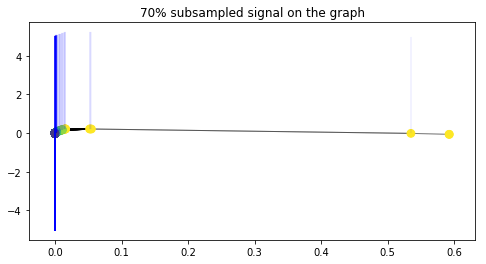

In [70]:
# Your code here.
plt.figure(figsize=[8, 4])
graph_visual(signal_subsample_70)
plt.title("70% subsampled signal on the graph")
plt.show()

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [78]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [73]:
def P(a):
    #Your code here
    b = a.copy()
    b[np.where(w == 1)[0]] = labels_bin[np.where(w == 1)[0]]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [83]:
# Compute gradient matrix
gradient_matrix_T = sparse.csr_matrix(compute_gradient_matrix(adjacency))

In [86]:
sol_1norm_min = graph_pnorm_interpolation(gradient_matrix_T, P, x0=np.random.randn(n_nodes), p=1.)

Solution found after 61 iterations:
    objective function f(sol) = 5.072069e+06
    stopping criterion: RTOL


In [87]:
sol_1norm_min

array([-1.00050959, -1.00050191,  0.23151003, ...,  6.65671346,
       -1.00045985, -1.00048788])

In [88]:
sol_2norm_min = graph_pnorm_interpolation(gradient_matrix_T, P, x0=np.random.randn(n_nodes), p=2.)

Solution found after 200 iterations:
    objective function f(sol) = 4.987769e+05
    stopping criterion: MAXIT


In [89]:
sol_2norm_min

array([-1.00000034, -1.00000034,  0.19815457, ...,  0.49157169,
       -1.00000029, -1.00000032])

In [90]:
# Binarized versions
threshold = 0

sol_1norm_bin = sol_1norm_min.copy()
sol_1norm_bin[sol_1norm_min >= threshold] = 1
sol_1norm_bin[sol_1norm_min < threshold] = -1
sol_1norm_bin

array([-1., -1.,  1., ...,  1., -1., -1.])

In [91]:
sol_2norm_bin = sol_2norm_min.copy()
sol_2norm_bin[sol_2norm_min >= threshold] = 1
sol_2norm_bin[sol_2norm_min < threshold] = -1
sol_2norm_bin

array([-1., -1.,  1., ...,  1., -1., -1.])

Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

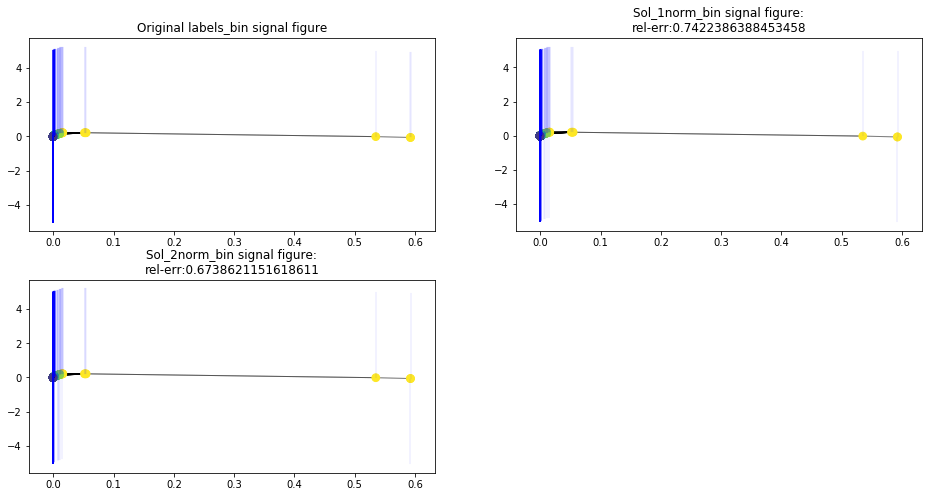

In [94]:
fig = plt.figure(figsize=[16,8])
fig.subplots_adjust(hspace=0.25)

plt.subplot(221)
graph_visual(labels_bin)
plt.title("Original labels_bin signal figure")

plt.subplot(222)
graph_visual(sol_1norm_bin)
rel_err_1 = np.linalg.norm(labels_bin - sol_1norm_bin) / np.linalg.norm(labels_bin)
plt.title("Sol_1norm_bin signal figure:\nrel-err:{}".format(rel_err_1))

plt.subplot(223)
graph_visual(sol_2norm_bin)
rel_err_2 = np.linalg.norm(labels_bin - sol_2norm_bin) / np.linalg.norm(labels_bin)
plt.title("Sol_2norm_bin signal figure:\nrel-err:{}".format(rel_err_2))

plt.show()

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see **what is the effect of the number of measurements** on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for **varying numbers of measurements and thresholding values**. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [95]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    global w
    pt_matrix = np.zeros((len(thresholds), len(mn_ratios)))
    for i in range(len(thresholds)):
        for j in range(len(mn_ratios)):
            threshold = thresholds[i]
            mn_ratio = mn_ratios[j]
            m = int(mn_ratio * len(labels_bin))  
            err = 0
            # Create sample mask
            for k in range(n_trials):
                random_index = np.random.permutation(len(labels_bin))
                subsample_index = random_index[:m]
                w = np.zeros(len(labels_bin))
                w[subsample_index]=1
                # Solve p-norm interpolation.
                sol_norm_min = graph_pnorm_interpolation(gradient_matrix_T, P, x0=np.random.randn(n_nodes), p=p)
                sol_norm_bin = sol_norm_min.copy()
                sol_norm_bin[sol_norm_min>=threshold] = 1
                sol_norm_bin[sol_norm_min<threshold] = -1
                err += np.linalg.norm(labels_bin-sol_norm_bin)/np.linalg.norm(labels_bin)
            err = err/n_trials
            # Aggregate.
            pt_matrix[i, j] = err
    return pt_matrix

In [96]:
mn_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

thresholds = [-1, -0.5, 0, 0.5, 1]
 
# -------- Uncommented: to compute matrix and save it ----------- #
# pt_matrix_1norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, 1)
# np.save('pt_matrix_1norm.npy', pt_matrix_1norm)
pt_matrix_1norm = np.load('pt_matrix_1norm.npy')

# pt_matrix_2norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, 2)
# np.save('pt_matrix_2norm.npy', pt_matrix_2norm)
pt_matrix_2norm = np.load('pt_matrix_2norm.npy')

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

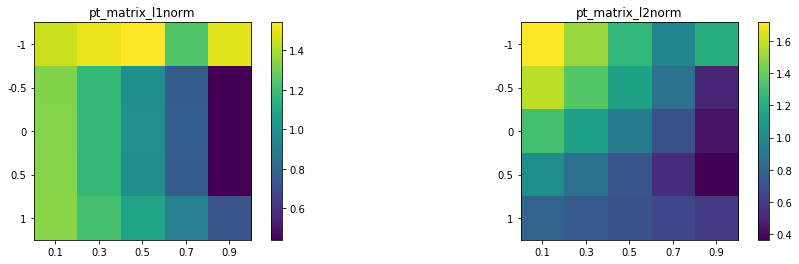

In [114]:
# Plot both phase transition matrices as images with a colorbar
x = ["0.1", "0.3", "0.5", "0.7", "0.9"]
y = ["-1", "-0.5", "0", "0.5", "1" ]

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
im = ax[0].imshow(pt_matrix_1norm)
ax[0].set_xticks(np.arange(len(x)))
ax[0].set_yticks(np.arange(len(y)))
ax[0].set_xticklabels(x)
ax[0].set_yticklabels(y)
ax[0].set_title('pt_matrix_l1norm')
plt.sca(ax[0])
plt.imshow(pt_matrix_1norm)
plt.colorbar()


im = ax[1].imshow(pt_matrix_2norm)
ax[1].set_xticks(np.arange(len(x)))
ax[1].set_yticks(np.arange(len(y)))
ax[1].set_xticklabels(x)
ax[1].set_yticklabels(y)
ax[1].set_title('pt_matrix_l2norm')
plt.sca(ax[1])
plt.imshow(pt_matrix_2norm)
plt.colorbar()

plt.show()

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Your answer here.**

>2-norm is better than 1-norm. As shown in the plot, when using the same threshold and the same ratio, the error is smaller under the 2-norm case. In addition, as mn_ratio gets bigger, the error decreases, because the more elements we keep, it is easier to reconstruct. The phase transition plot gives us insight to choose our best threshold based on the error.

---